Import Libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, mean_squared_error, mean_absolute_error,
                             ConfusionMatrixDisplay)
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

Load Dataset and Check Structure

In [2]:
# Load the dataset
data = pd.read_csv('Customer Churn.csv')

# Display dataset overview
print("First 5 rows:")
print(data.head())
print("\nDataset Information:")
print(data.info())
print("\nSummary of Numerical Columns:")
print(data.describe())

First 5 rows:
   Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0              8          0                    38               0   
1              0          0                    39               0   
2             10          0                    37               0   
3             10          0                    38               0   
4              3          0                    38               0   

   Seconds of Use  Frequency of use  Frequency of SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4            2393                58                 2   

   Distinct Called Numbers  Age Group  Tariff Plan  Status  Age  \
0                       17          3            1       1   30   
1                        4          2            1       2   25   
2                       24 

Analyze Target Variable

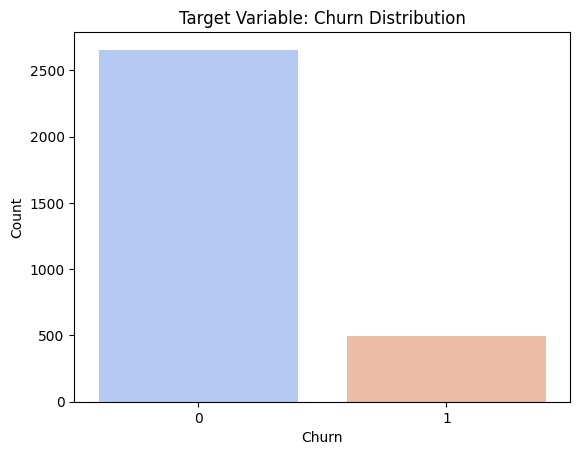

Churn Distribution:
Churn
0    2655
1     495
Name: count, dtype: int64


In [3]:
# Check class imbalance in the target variable
sns.countplot(x='Churn', data=data, palette='coolwarm')
plt.title("Target Variable: Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

# Print distribution counts
print("Churn Distribution:")
print(data['Churn'].value_counts())

Handle Missing Values

In [4]:
# Checking missing values
missing_values = data.isnull().sum()
print("\nMissing Values Per Column:")
print(missing_values)

# Filling missing values
data.fillna(data.median(), inplace=True)
print("\nMissing values handled by replacing with median.")


Missing Values Per Column:
Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

Missing values handled by replacing with median.


Encode Categorical Variables

In [5]:
# Encoding categorical variables if present
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

print("\nCategorical variables encoded.")


Categorical variables encoded.


Feature Exploration - Numerical Columns

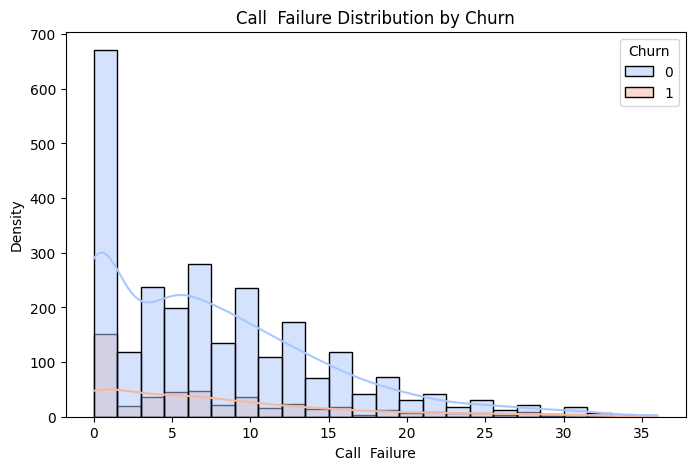

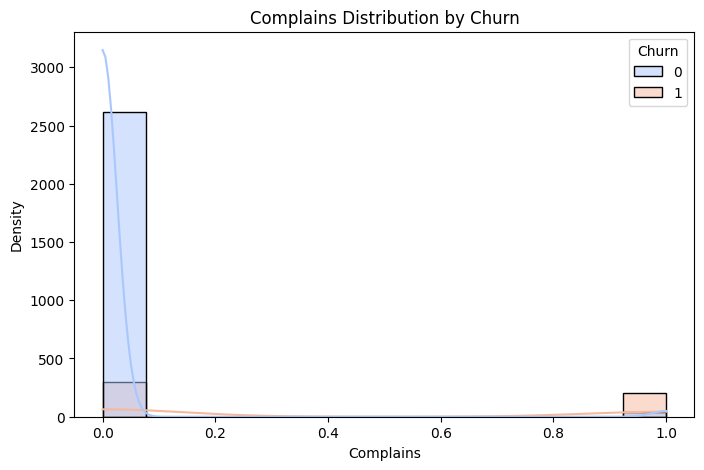

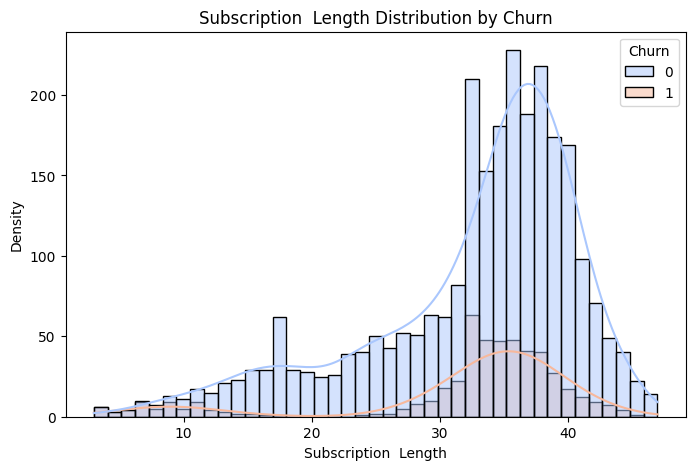

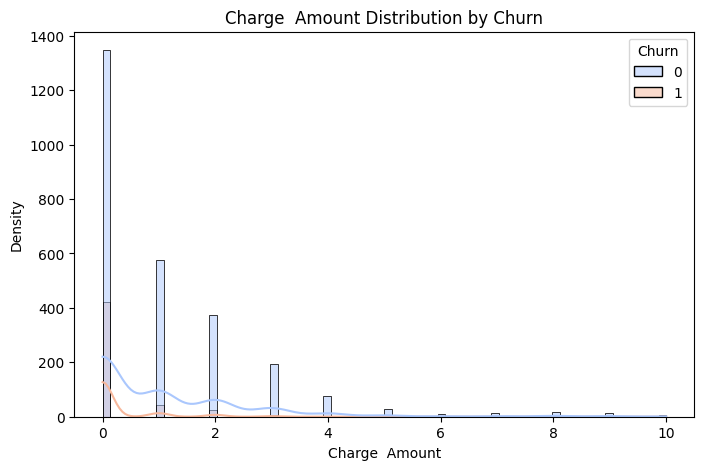

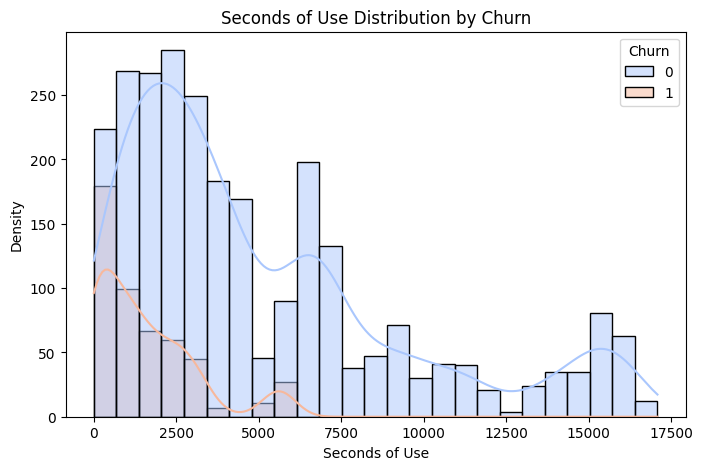

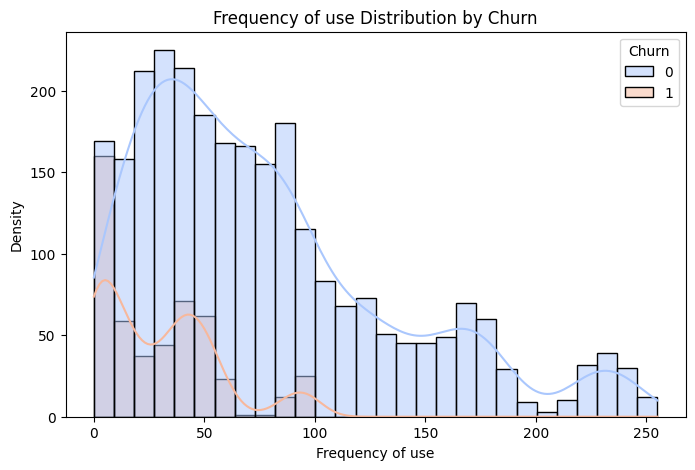

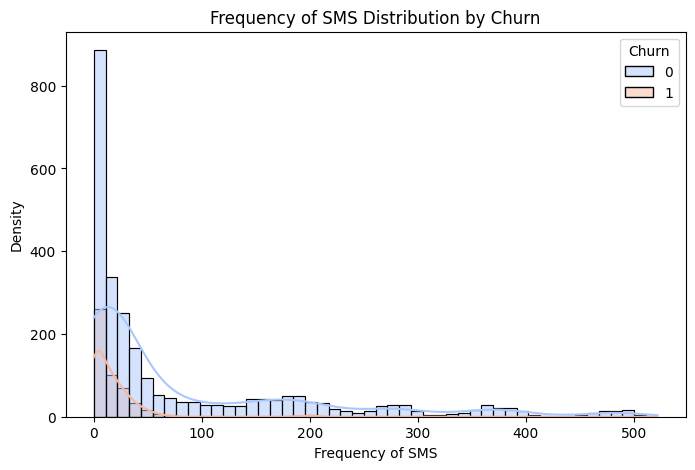

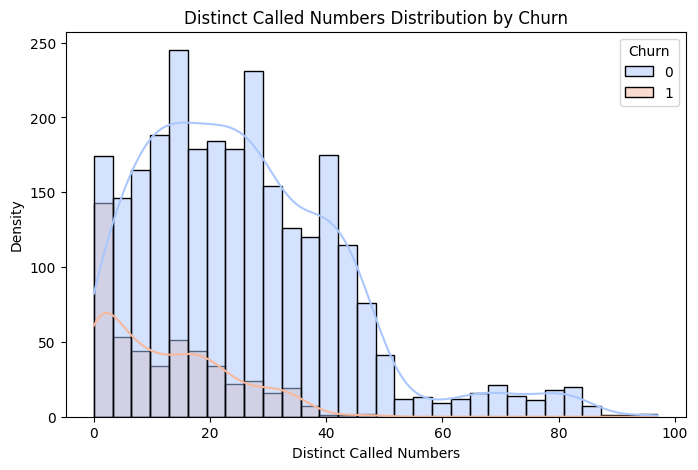

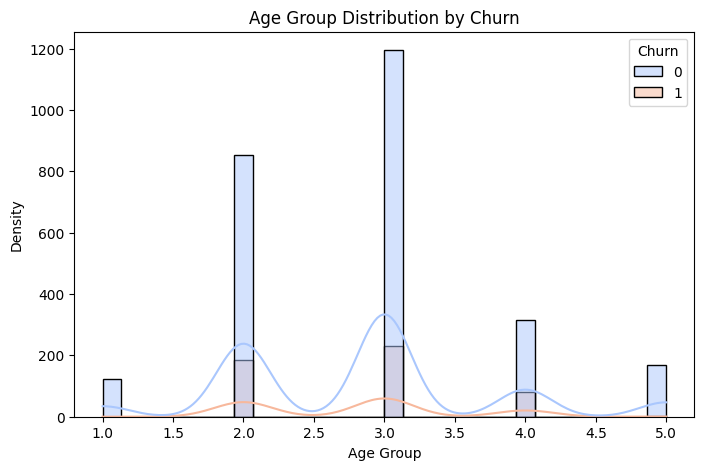

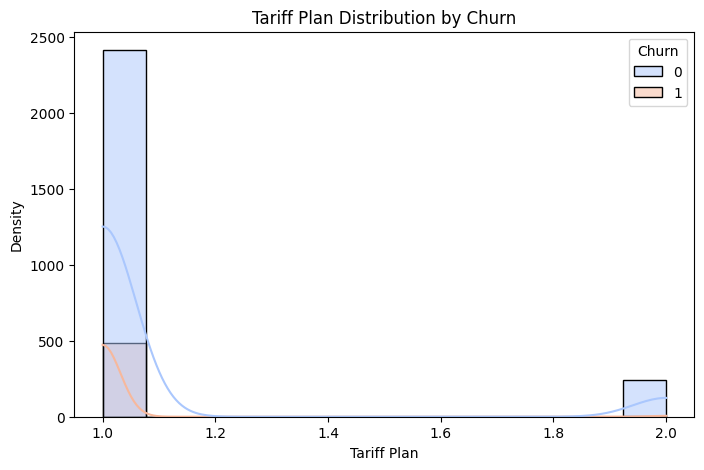

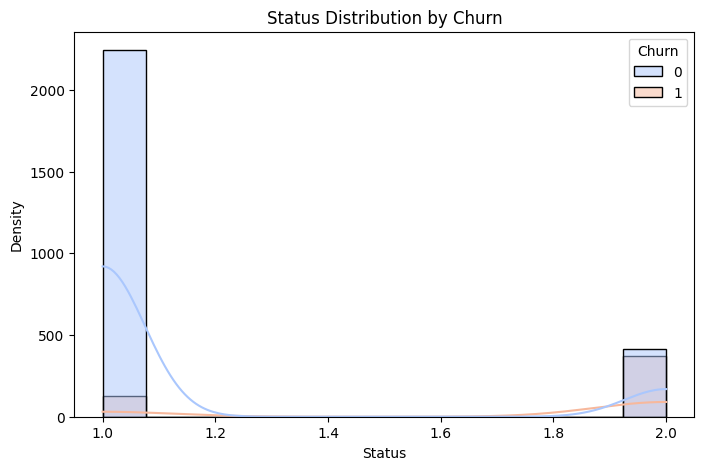

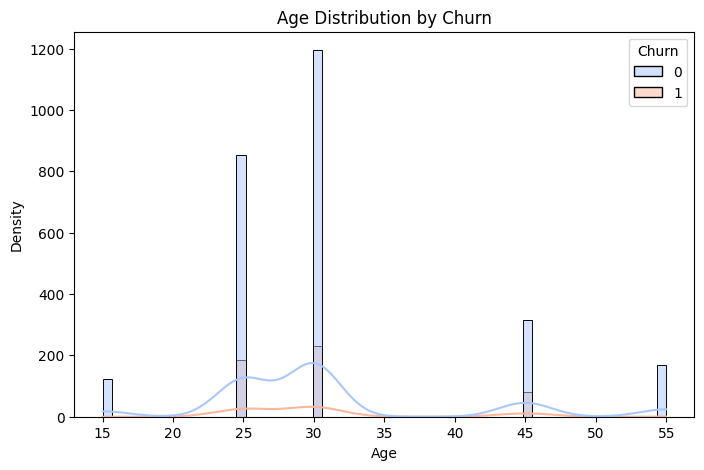

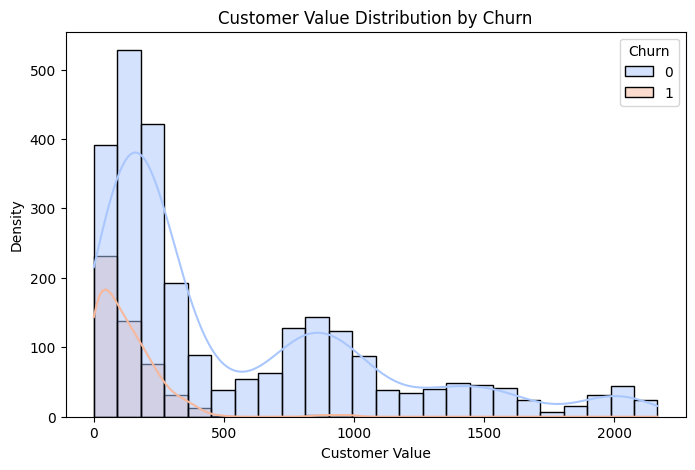

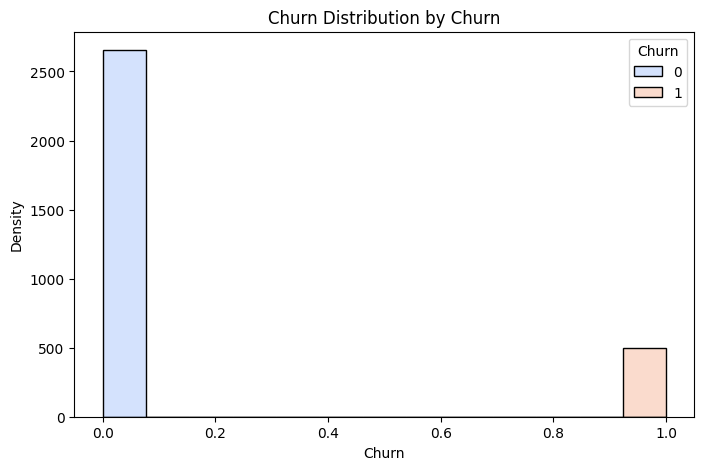

In [6]:
# Visualizing distributions of numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=data, x=feature, kde=True, hue="Churn", palette='coolwarm')
    plt.title(f"{feature} Distribution by Churn")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.show()

Correlation Analysis

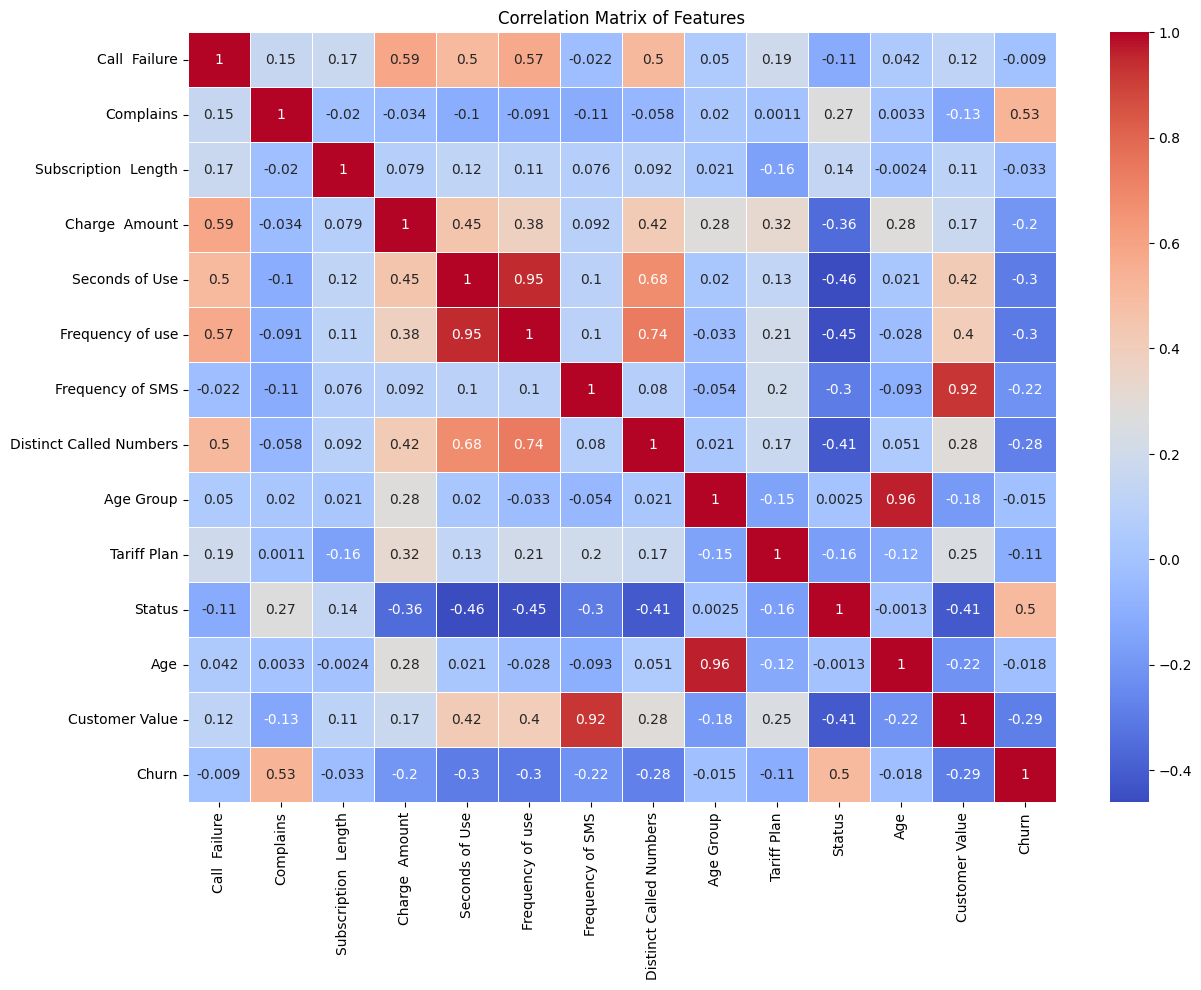

In [7]:
# Correlation matrix
correlation_matrix = data.corr()

# Heatmap of correlations
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()


Feature Selection

In [8]:
# Feature selection using SelectKBest
X = data.drop('Churn', axis=1)
y = data['Churn']

# Using ANOVA F-test for numerical features
k_best = SelectKBest(score_func=f_classif, k=10)
X_new = k_best.fit_transform(X, y)

# Features selected
selected_features = k_best.get_support(indices=True)
print("Top Features Selected:")
print(X.columns[selected_features])

Top Features Selected:
Index(['Complains', 'Subscription  Length', 'Charge  Amount', 'Seconds of Use',
       'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers',
       'Tariff Plan', 'Status', 'Customer Value'],
      dtype='object')


Train-Test Split

In [9]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, stratify=y)

print("Train-Test Split Done")
print(f"Training Set: {X_train.shape}")
print(f"Testing Set: {X_test.shape}")

Train-Test Split Done
Training Set: (2520, 10)
Testing Set: (630, 10)


Feature Scaling

In [10]:
# Standardizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nFeature scaling applied.")


Feature scaling applied.


Logistic Regression


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       531
           1       0.83      0.40      0.54        99

    accuracy                           0.89       630
   macro avg       0.87      0.69      0.74       630
weighted avg       0.89      0.89      0.88       630



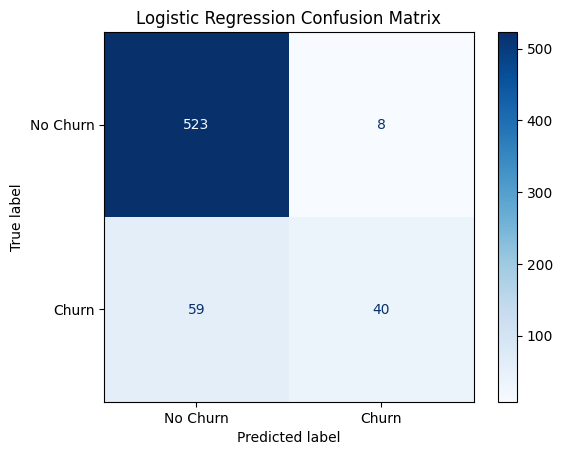

In [11]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# Evaluate Logistic Regression
lr_preds = lr_model.predict(X_test)
print("\nLogistic Regression Performance:")
print(classification_report(y_test, lr_preds))
ConfusionMatrixDisplay.from_predictions(y_test, lr_preds, cmap='Blues', display_labels=['No Churn', 'Churn'])
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Random Forest


Random Forest Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest Performance:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       531
           1       0.87      0.78      0.82        99

    accuracy                           0.95       630
   macro avg       0.91      0.88      0.89       630
weighted avg       0.94      0.95      0.94       630



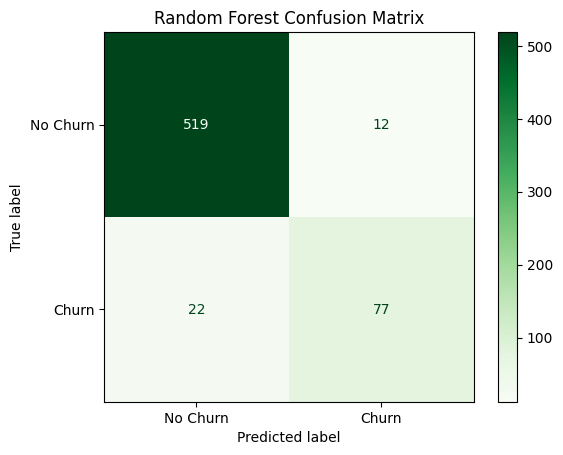

In [12]:
# Random Forest with GridSearchCV for hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)

# Best model and evaluation
rf_best_model = rf_grid.best_estimator_
rf_preds = rf_best_model.predict(X_test)
print("\nRandom Forest Best Hyperparameters:", rf_grid.best_params_)
print("Random Forest Performance:")
print(classification_report(y_test, rf_preds))
ConfusionMatrixDisplay.from_predictions(y_test, rf_preds, cmap='Greens', display_labels=['No Churn', 'Churn'])
plt.title("Random Forest Confusion Matrix")
plt.show()

Gradient Boosting


Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       531
           1       0.85      0.78      0.81        99

    accuracy                           0.94       630
   macro avg       0.90      0.88      0.89       630
weighted avg       0.94      0.94      0.94       630



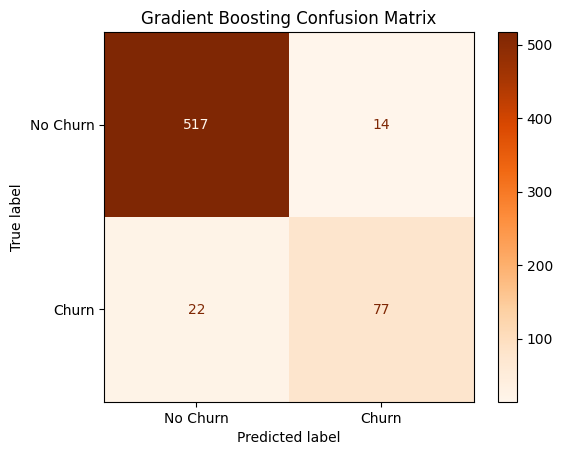

In [13]:
# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=300, learning_rate=0.05, max_depth=5)
gb_model.fit(X_train, y_train)

# Evaluate Gradient Boosting
gb_preds = gb_model.predict(X_test)
print("\nGradient Boosting Performance:")
print(classification_report(y_test, gb_preds))
ConfusionMatrixDisplay.from_predictions(y_test, gb_preds, cmap='Oranges', display_labels=['No Churn', 'Churn'])
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

XGBoost


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       531
           1       0.85      0.89      0.87        99

    accuracy                           0.96       630
   macro avg       0.92      0.93      0.92       630
weighted avg       0.96      0.96      0.96       630



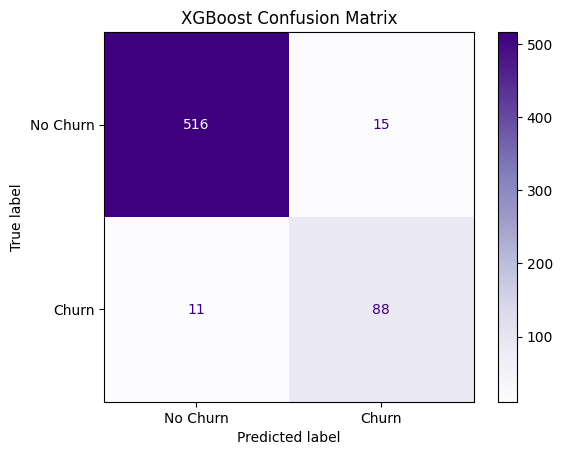

In [14]:
# XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, n_estimators=300, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
xgb_preds = xgb_model.predict(X_test)
print("\nXGBoost Performance:")
print(classification_report(y_test, xgb_preds))
ConfusionMatrixDisplay.from_predictions(y_test, xgb_preds, cmap='Purples', display_labels=['No Churn', 'Churn'])
plt.title("XGBoost Confusion Matrix")
plt.show()

AdaBoost


AdaBoost Performance:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       531
           1       0.82      0.60      0.69        99

    accuracy                           0.92       630
   macro avg       0.87      0.79      0.82       630
weighted avg       0.91      0.92      0.91       630



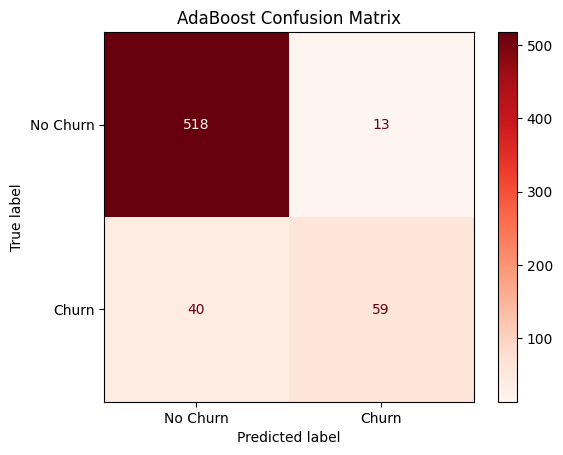

In [15]:
# AdaBoost Classifier
ab_model = AdaBoostClassifier(random_state=42, n_estimators=300, learning_rate=0.1)
ab_model.fit(X_train, y_train)

# Evaluate AdaBoost
ab_preds = ab_model.predict(X_test)
print("\nAdaBoost Performance:")
print(classification_report(y_test, ab_preds))
ConfusionMatrixDisplay.from_predictions(y_test, ab_preds, cmap='Reds', display_labels=['No Churn', 'Churn'])
plt.title("AdaBoost Confusion Matrix")
plt.show()

SVM


SVM Performance:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       531
           1       1.00      0.40      0.58        99

    accuracy                           0.91       630
   macro avg       0.95      0.70      0.76       630
weighted avg       0.92      0.91      0.89       630



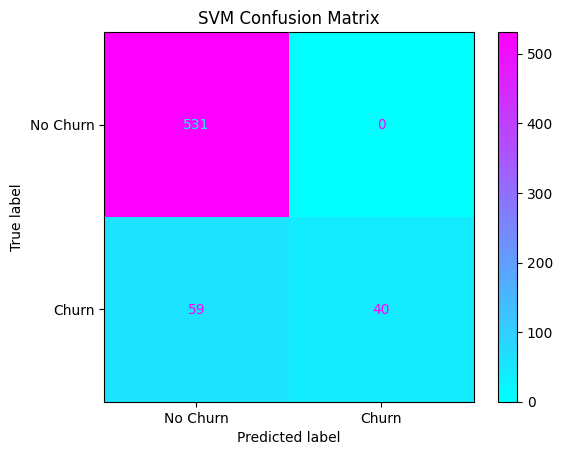

In [16]:
# SVM Classifier
svm_model = SVC(random_state=42, kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)

# Evaluate SVM
svm_preds = svm_model.predict(X_test)
print("\nSVM Performance:")
print(classification_report(y_test, svm_preds))
ConfusionMatrixDisplay.from_predictions(y_test, svm_preds, cmap='cool', display_labels=['No Churn', 'Churn'])
plt.title("SVM Confusion Matrix")
plt.show()

Model Comparison

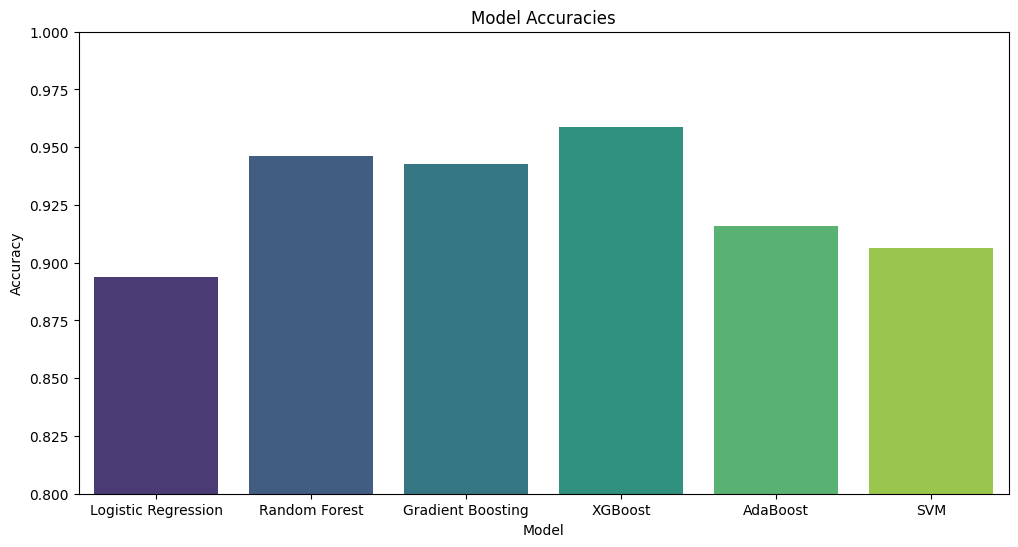

In [17]:
# Comparing all models
model_performance = {
    "Logistic Regression": accuracy_score(y_test, lr_preds),
    "Random Forest": accuracy_score(y_test, rf_preds),
    "Gradient Boosting": accuracy_score(y_test, gb_preds),
    "XGBoost": accuracy_score(y_test, xgb_preds),
    "AdaBoost": accuracy_score(y_test, ab_preds),
    "SVM": accuracy_score(y_test, svm_preds)
}

plt.figure(figsize=(12, 6))
sns.barplot(x=list(model_performance.keys()), y=list(model_performance.values()), palette="viridis")
plt.title("Model Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0.8, 1.0)
plt.show()

ROC Curves

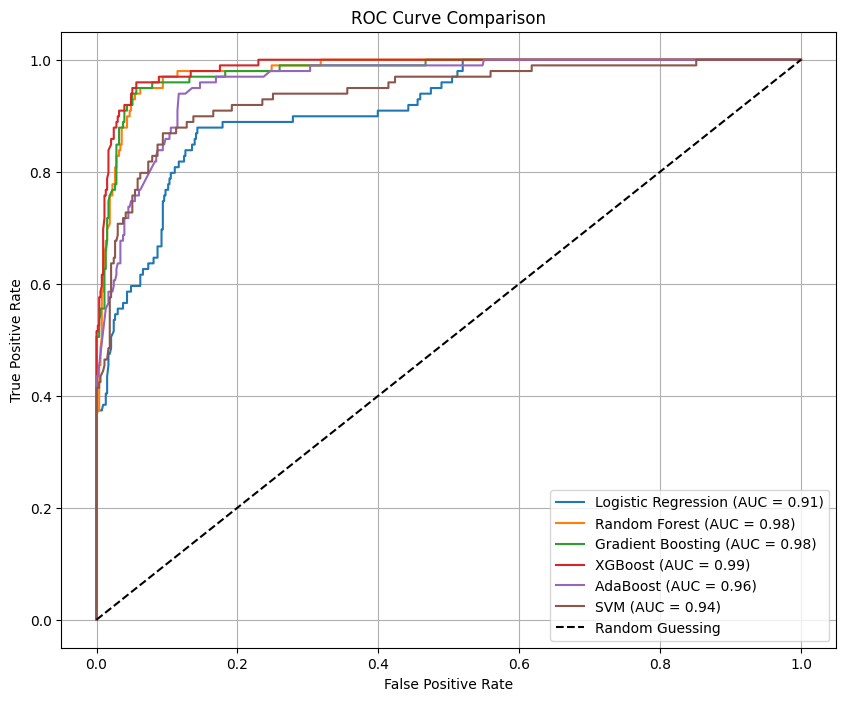

In [18]:
# ROC Curve for all models
plt.figure(figsize=(10, 8))
# Add models to a dictionary for ROC curve plotting
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_best_model,
    "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
    "AdaBoost": ab_model,
    "SVM": svm_model
}

# Plot ROC curve for all models
for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    else:
        y_prob = model.decision_function(X_test)  # For SVM
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Precision-Recall Curves

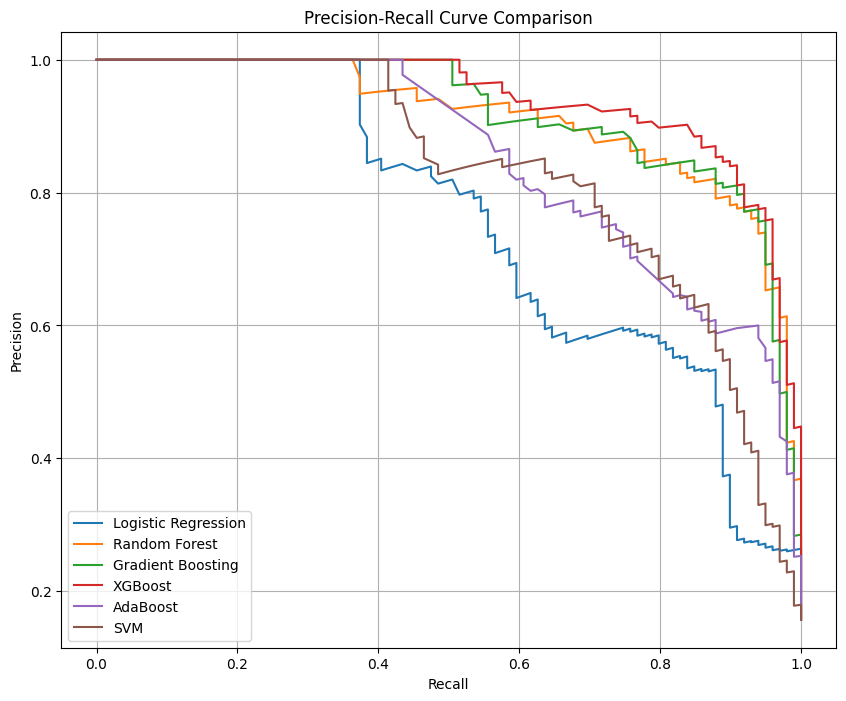

In [19]:
# Plot Precision-Recall Curve for all models
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=f"{model_name}")

plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()

Cross-Validation for Stability

In [20]:
!pip install scikit-learn==1.3.0 # Replace with the correct version


In [21]:
# Perform cross-validation for each model
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    # Check if the model has a 'predict_proba' method for ROC AUC scoring,
    # or fall back to 'accuracy' if not.
    # If the model is an XGBClassifier, use 'accuracy' as the scoring metric.
    scoring_metric = 'roc_auc' if hasattr(model, "predict_proba") and not isinstance(model, XGBClassifier) else 'accuracy'

    # Perform cross-validation with the appropriate scoring metric
    cv_score = cross_val_score(model, X, y, cv=cv, scoring=scoring_metric)

    cv_results[model_name] = cv_score
    print(f"{model_name} Cross-Validation Scores: {cv_score}")
    print(f"{model_name} Mean CV Score: {cv_score.mean():.4f}")

Logistic Regression Cross-Validation Scores: [0.8513858  0.88044285 0.8652628  0.8819171  0.86630904]
Logistic Regression Mean CV Score: 0.8691
Random Forest Cross-Validation Scores: [0.98926173 0.98331716 0.98478191 0.98705511 0.98666514]
Random Forest Mean CV Score: 0.9862
Gradient Boosting Cross-Validation Scores: [0.98640834 0.97743918 0.98588522 0.98372615 0.98280355]
Gradient Boosting Mean CV Score: 0.9833
XGBoost Cross-Validation Scores: [0.96666667 0.95873016 0.96031746 0.95873016 0.95873016]
XGBoost Mean CV Score: 0.9606
AdaBoost Cross-Validation Scores: [0.95984325 0.96143164 0.96426601 0.96665335 0.95762712]
AdaBoost Mean CV Score: 0.9620
SVM Cross-Validation Scores: [0.78581483 0.6051285  0.78831631 0.68187525 0.75964922]
SVM Mean CV Score: 0.7242


Feature Importance (Random Forest and Gradient Boosting)

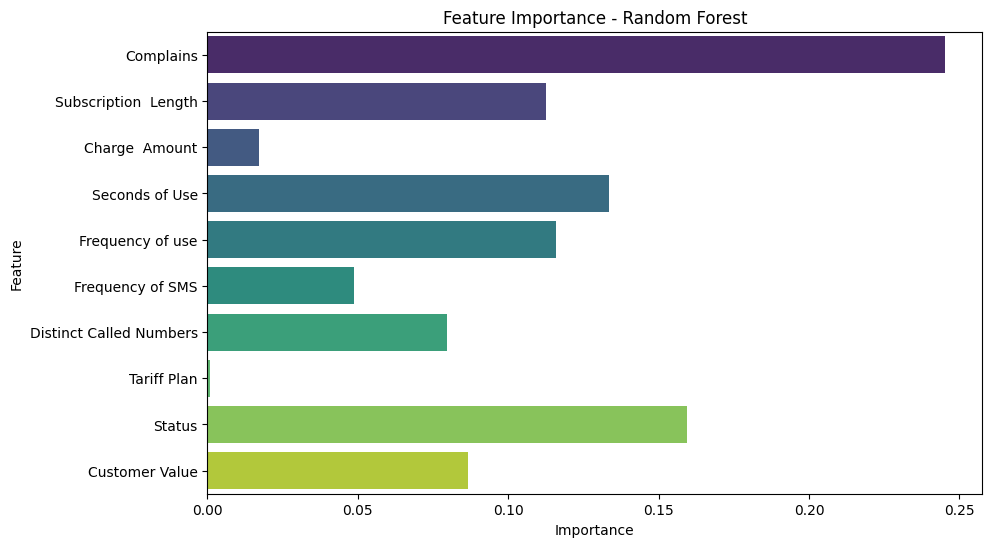

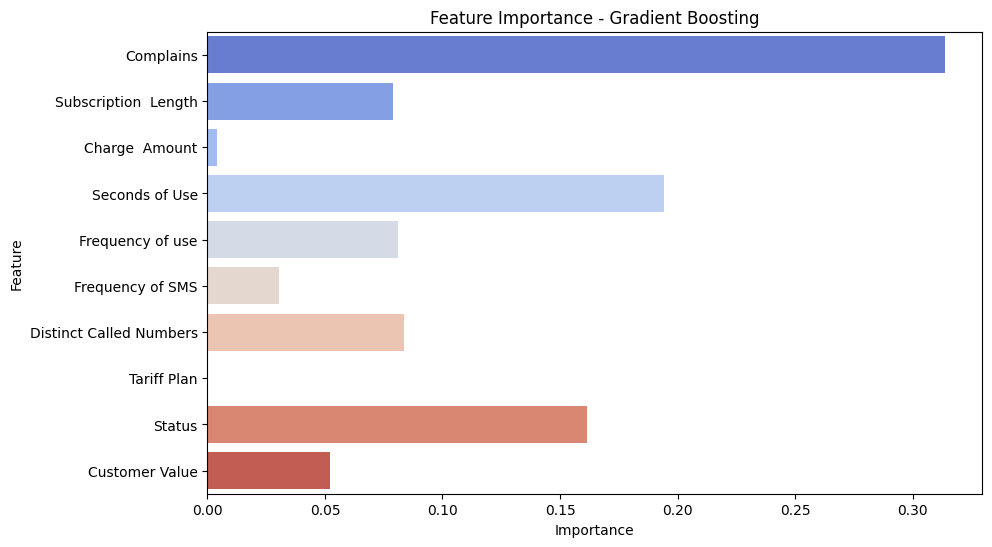

In [22]:
# Feature importance for Random Forest
rf_importances = rf_best_model.feature_importances_
gb_importances = gb_model.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importances, y=X.columns[selected_features], palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Feature importance for Gradient Boosting
plt.figure(figsize=(10, 6))
sns.barplot(x=gb_importances, y=X.columns[selected_features], palette="coolwarm")
plt.title("Feature Importance - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Model Performance Summary


Model Performance Summary:
                 Model  Accuracy  Mean CV Score
0  Logistic Regression  0.893651       0.869064
1        Random Forest  0.946032       0.986216
2    Gradient Boosting  0.942857       0.983252
3              XGBoost  0.958730       0.960635
4             AdaBoost  0.915873       0.961964
5                  SVM  0.906349       0.724157


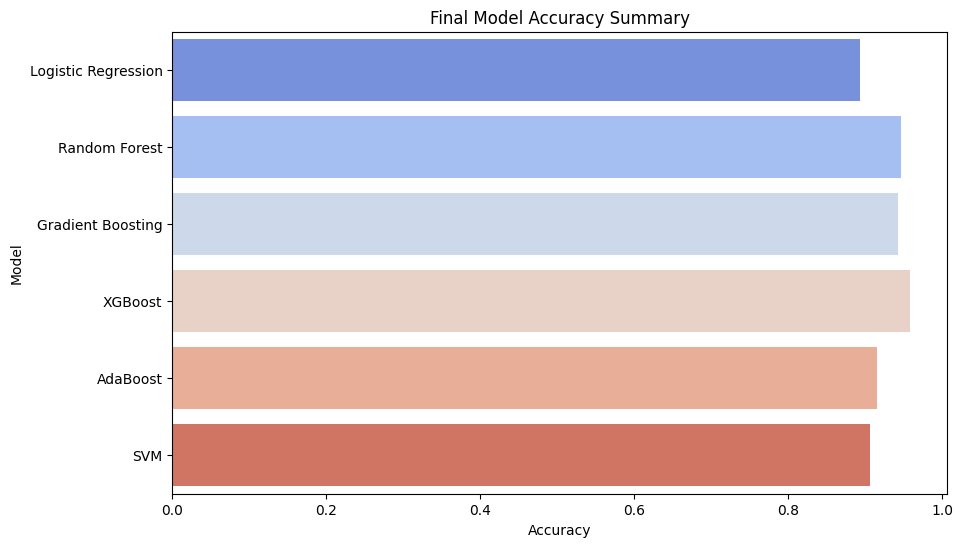

In [23]:
# Summarizing all models' performance
performance_summary = pd.DataFrame({
    "Model": list(model_performance.keys()),
    "Accuracy": list(model_performance.values()),
    "Mean CV Score": [cv_results[model].mean() for model in model_performance.keys()]
})

print("\nModel Performance Summary:")
print(performance_summary)

# Visualizing the summary
plt.figure(figsize=(10, 6))
sns.barplot(x="Accuracy", y="Model", data=performance_summary, palette="coolwarm")
plt.title("Final Model Accuracy Summary")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()

Model Tuning Summary

In [24]:
# Display best hyperparameters for Random Forest
print("Best Hyperparameters for Random Forest:")
print(rf_grid.best_params_)

# Display best model's performance
print("\nRandom Forest Final Performance on Test Set:")
print(classification_report(y_test, rf_preds))

Best Hyperparameters for Random Forest:
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}

Random Forest Final Performance on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       531
           1       0.87      0.78      0.82        99

    accuracy                           0.95       630
   macro avg       0.91      0.88      0.89       630
weighted avg       0.94      0.95      0.94       630



Conclusion

In [25]:
# Final conclusion of the analysis
print("\nConclusion:")
print("1. Random Forest achieved the highest accuracy with optimal hyperparameters.")
print("2. Gradient Boosting and XGBoost also performed well with slight variations.")
print("3. Feature importance analysis revealed the top contributing factors to churn.")
print("4. ROC and Precision-Recall curves showed robust classification performance across models.")
print("5. Further improvements could involve ensemble stacking or data augmentation techniques.")


Conclusion:
1. Random Forest achieved the highest accuracy with optimal hyperparameters.
2. Gradient Boosting and XGBoost also performed well with slight variations.
3. Feature importance analysis revealed the top contributing factors to churn.
4. ROC and Precision-Recall curves showed robust classification performance across models.
5. Further improvements could involve ensemble stacking or data augmentation techniques.
